# Setup

This project requires Python 3.7 or above

In [35]:
import sys

assert sys.version_info >= (3, 7)

And Tensorflow >= 2.8:

In [36]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [37]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [38]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

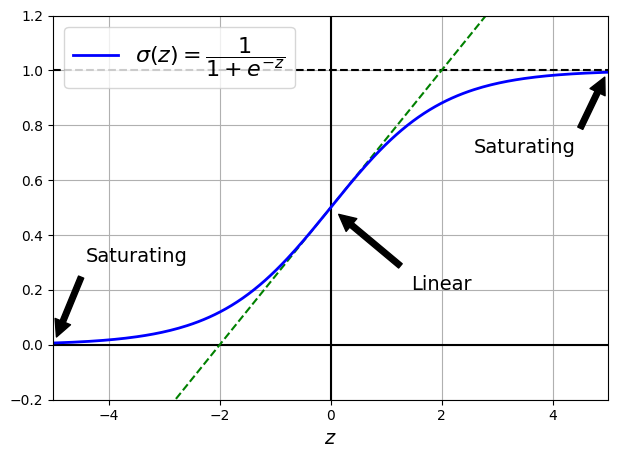

In [39]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
              fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when makeing predictions, and in the reverse direction when backpropagating gradients. We don't want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (these numbers are called *fan-in* and *fan-out* of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation given below where $fan_{avg}=(fan_{in}+fan_{out}) / 2$. This initialization is called *Xavier initialization* or *Glorot initialization*, after the paper's first author. 

*Glorot initialization (when using the sigmoid activation function)*

Normal distribution with mean 0 and variance $\sigma^2 = \frac{1}{fan_{avg}}$
Or a uniform distribution between $-r$ amd $+r$, with $r = \sqrt{\frac{3}{fan_{avg}}}$

If you replace $fan_{avg}$ with $fan_{in}$ in the above equation, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*.

| Initializattion | Activation funtions | $\sigma^2 (Normal)$ |
| --- | --- | --- |
| Glorot | None, tanh, sigmoid, softmax | $\frac{1}{fan_{avg}}$ |
| He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $\frac{2}{fan_{avg}}$ |
| LeCun | SELU | $\frac{1}{fan_{in}}$ |

In [40]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [41]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

ReLU activation function, mostly because it does not saturate for positive values, and also because it is very fast to compute behaves much better in deep neural networks.

Unfortunately, the ReLU activation function is not perfect. It suffers from a problee know as the *dying ReLUs*: during training, some neurons effectively "die", meaning they stop outputting anything other than 0. In some cases, you may find that half of your network's neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron's inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the *leaky ReLU*.

## Nonsaturating Activation Functions

### Leky ReLU

$LeakyReLU_\alpha (z) = max(\alpha{z}, z)$
The hyperparameter $\alpha$ defines how much the function "leaks": it is the slope of the function for $z<0$. Having a slope for $z<0$ ensures thaat leaky *ReLUs* never die, they can go into a long coma, but they have a chance to eventually wake up.

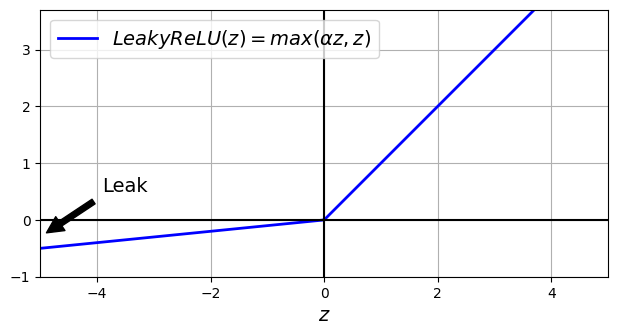

In [42]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), 'b-', linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

A 2015 paper by Bing Xu compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU acivation function. In fact, setting $\alpha = 0.2$ (a huge leak) seemed to result in better performance that $\alpha = 0.01$ (a small leak). The paper also evaluated the *randomized leaky ReLU* (RReLU), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. RReLU also performed fairly well and seemed to act as a regularizer, reducing the risk of overfitting the training set. Finally, the paper evaluated the *parametric leaky ReLU* PReLU, where $\alpha$ is authorized to be learned during training: instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter. PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of ovverfitting the training set.

In [43]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [44]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

ReLU, leaky ReLu and PReLU all suffer from the fact that they are not smooth functions: their derivatives abruptly change (at $z = 0$). This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence. So now we will look at the smooth variants of the ReLU activation function, starting with ELU and SELU.

### ELU

In 2015, a paper by Djork-Arne Clevert proposed a new activation function, called the *exponential linear unit* (ELU), that outperformed the ReLU variants in the author's experiments: training time was reduced, and the neural network performed better on the test set.

*ELU activation function*

$
ELU_\alpha (z) = 
    \begin{cases}
        \alpha(exp(z)-1) & \text{if } z < 0 \\
        z & \text{if } z \geq 0
    \end{cases}
$

The ELU activation function looks a lot like the ReLU function with a few major differences:

- It taes on negative values when $z < 0$, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
- It has a nonzero gradient for $z<0$, which avoids the dead neurons problem.
- If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z=0$, which helps speed up gradient descent since it does not bounce as much to the left and right of $z=0$.

In [45]:
dense = tf.keras.layers.Dense(50, activation="elu", 
                              kernel_initializer="he_normal")

### SELU

Not long after, a 2017 paper by Gunter Klambauer introduced the *scaled ELU* (SELU) activation function: as its name suggests it is a scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha \approx 1.67$). The authors showed that if you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function function may outperform other activation functions for MLPs, especially deep ones. There are, however, a few conditions for self-normalization to happen:

- The input features must be standardized: mean 0 and standard deviation: 0
- Every hidden layer's weights must be initialized using LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.
- The self-normalizing property is only guaranteed with plain MLPs. If you try to use SELU in other architectures, like recurrent networks or networks with *skip connections* (i.e., connections that skip layers, such as in Wide & Deep nets), it will probably not outperform ELU.
- You cannot use regularization techniques like $l_1$ or $l_2$ regularization, max-norm, batch-norm, or regular dropout.

By default, the SELU hyperparamaters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across the exploding/vanishing gradients problem:

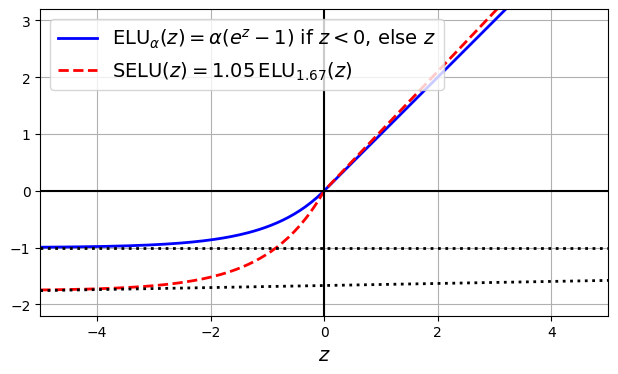

In [46]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper)
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k:", linewidth=2)
plt.plot([-5, 5], [-1.758, -1.578], "k:", linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()


In [47]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

__An example of a self-regularized network using SELU__

In [48]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [49]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Don't forget to scale the inputs to mean 0 and standard deviation 1

In [50]:
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [51]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [52]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

C:\Users\HP\AppData\Local\Temp\ipykernel_20168\2231411249.py:3: RuntimeWarning: invalid value encountered in divide
  X_train_scaled = (X_train - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_20168\2231411249.py:4: RuntimeWarning: invalid value encountered in divide
  X_valid_scaled = (X_valid - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_20168\2231411249.py:5: RuntimeWarning: divide by zero encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_20168\2231411249.py:5: RuntimeWarning: invalid value encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds


In [53]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 51s 28ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 42s 25ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 42s 24ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 42s 24ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 42s 24ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead.

In [54]:
tf.random.set_seed(42)

In [55]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [56]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [57]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 45s 25ms/step - loss: 2.1281 - accuracy: 0.2085 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 40s 23ms/step - loss: 1.5639 - accuracy: 0.3722 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 41s 24ms/step - loss: 1.2383 - accuracy: 0.4709 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 41s 24ms/step - loss: 1.0392 - accuracy: 0.5638 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 41s 24ms/step - loss: 0.9498 - accuracy: 0.6147 - val_loss: nan - val_accuracy: 0.0978


Not great at all, we suffered from the vanishing/exploding gradient problem.

### GELU, Swish and Mish

GELU wsa introduced in 2016 paper by Dan Hendrycks and Kevin Gimpel. Once again you can think of thi as a smooth variant of the ReLU activation function. Its definition is given in the equation below, where $\Phi$ is the standard Gaussian cumulative distribution function (CDF): $\Phi(z)$ corresponds to the probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower tha z.

$GELU(z) = z\Phi(z)$

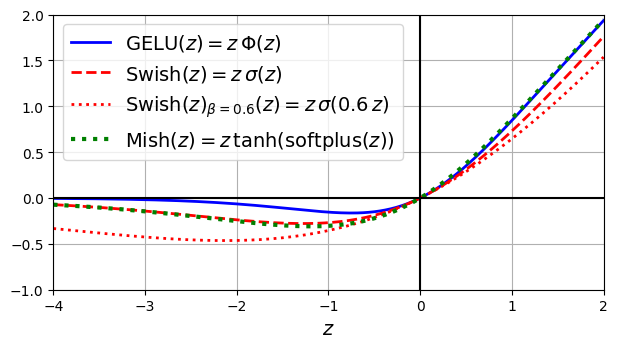

In [58]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$(z)_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], "k-")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In a 2015 paper, Sergey Ioffey and Christian Szegedy proposed a technique called *batch normalization* (BN) that addresses the problem of vanishing/exploding gradients. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model elarn the optimal scale and mean of each of the layer's inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set. That is, there is no need for `StandardScaler` or `Normalization`; the BN layer will do it for you (well, approximately, since it only looks at one batch at aa time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input's mean and standard deviation. It does so by evaluating the mean and standard deviation of th input over the curren mini-batch (hence the name "batch normalization")

Batch normalizing algorithm

1. $\boldsymbol{\mu}_{B} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} \boldsymbol{x}^{(i)}$
2. $\boldsymbol{\sigma}_{B}^{2} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} ({\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}})^{2}$
3. $\hat{\boldsymbol{x}}^{(i)} = \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}}{\sqrt{{\boldsymbol{\sigma}_B^{2}}+{\epsilon}}}$
4. $\boldsymbol{z}^{(i)}=\boldsymbol{\gamma}\otimes{\hat{\boldsymbol{x}}^{(i)}} + \boldsymbol{\beta}$

In this algorithm:
- $\boldsymbol{\mu}_{B}$ is the vector of input means, evaluated over the whole mini-batch _B_ (it contains one mean per input).
- $m_B$ is the number of instances in the mini-batch.
- $\boldsymbol{\sigma}_{B}$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).
- $\hat{\boldsymbol{x}^{(i)}}$ is the vector of zero-centered and normalized inputs for instance _i_.
- $\epsilon$ is a tiny number that avoids division by zero and ensures the gradients don't grow too large (typically $10^{-5}$). This is called _smoothing term_.
- $\boldsymbol{\gamma}$ is the output scale parameter vector for the layer (each input is multiplied by its correcter per input).
- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).
- $\boldsymbol{\beta}$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.
- **z**<sup>(i)</sup> is the output of the BN operation. It is a rescaled and shifted version of the inputs. 

In [59]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [62]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [63]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 11s 6ms/step - loss: 0.3995 - accuracy: 0.8795 - val_loss: 0.1704 - val_accuracy: 0.9526
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2047 - accuracy: 0.9398 - val_loss: 0.1329 - val_accuracy: 0.9616


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [66]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4626 - accuracy: 0.8741 - val_loss: 0.1714 - val_accuracy: 0.9570
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2233 - accuracy: 0.9362 - val_loss: 0.1241 - val_accuracy: 0.9670


Ioffe and Szegedy demonstrated that batch normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as tanh and even the sigmoid activation function. The networks were much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process.

Finally, like a gift that keeps on giving, batch normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout)

Batch normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it's often possible to fuse the BN layer with the previous layer's after training, thereby avoiding the runtime penalty. This is done by updating the previous layer's weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $\bm{X}\bm{W}+\bm{b}$, then the BN layer will compute $\gamma \otimes (\bm{X}\bm{W}+\bm{b}-\mu) / \sigma + \beta$ (ignoring the smoothing term $\epsilon$ in the denominator). If we define $\bm{W\prime} = \gamma \otimes \bm{W} / \sigma$ and $\bm{b\prime} = \gamma \otimes (\bm{b} - \bm{\mu}) + \beta$, the equation simplifies to $\bm{X}\bm{W\prime}+\bm{b\prime}$. So, if we replace the previous layer's weights and biases ($\bm{W}$ and $\bm{b}$), we can get rid of the updated weight and biases ($\bm{W\prime}$ and $\bm{b\prime}$), we can get rid of the BN layer.

## Gradient Clipping

Technique to mitigate exploding gradients problem.

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [67]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [68]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
- `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try reusing it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [69]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1379/1379 [==============================] - 5s 4ms/step - loss: 1.6090 - accuracy: 0.5067 - val_loss: 0.9888 - val_accuracy: 0.8006
Epoch 2/20
1379/1379 [==============================] - 5s 3ms/step - loss: 0.7514 - accuracy: 0.8101 - val_loss: 0.4708 - val_accuracy: 0.8890
Epoch 3/20
1379/1379 [==============================] - 5s 4ms/step - loss: 0.4803 - accuracy: 0.8665 - val_loss: 0.3370 - val_accuracy: 0.9139
Epoch 4/20
1379/1379 [==============================] - 5s 4ms/step - loss: 0.3871 - accuracy: 0.8884 - val_loss: 0.2851 - val_accuracy: 0.9223
Epoch 5/20
1379/1379 [==============================] - 4s 3ms/step - loss: 0.3405 - accuracy: 0.9005 - val_loss: 0.2559 - val_accuracy: 0.9291
Epoch 6/20
1379/1379 [==============================] - 6s 4ms/step - loss: 0.3110 - accuracy: 0.9083 - val_loss: 0.2363 - val_accuracy: 0.9328
Epoch 7/20
1379/1379 [==============================] - 5s 4ms/step - loss: 0.2898 - accuracy: 0.9142 - val_loss: 0.2245 - val_accuracy:

In [70]:
# train and evaluate model B, without using model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20


7/7 [==============================] - 1s 59ms/step - loss: 0.7071 - accuracy: 0.5150 - val_loss: 0.7032 - val_accuracy: 0.5193
Epoch 2/20
7/7 [==============================] - 0s 25ms/step - loss: 0.6986 - accuracy: 0.5350 - val_loss: 0.6954 - val_accuracy: 0.5397
Epoch 3/20
7/7 [==============================] - 0s 24ms/step - loss: 0.6906 - accuracy: 0.5600 - val_loss: 0.6875 - val_accuracy: 0.5662
Epoch 4/20
7/7 [==============================] - 0s 24ms/step - loss: 0.6829 - accuracy: 0.5650 - val_loss: 0.6800 - val_accuracy: 0.5855
Epoch 5/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6758 - accuracy: 0.5900 - val_loss: 0.6729 - val_accuracy: 0.6100
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6687 - accuracy: 0.6150 - val_loss: 0.6656 - val_accuracy: 0.6426
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6616 - accuracy: 0.6300 - val_loss: 0.6587 - val_accuracy: 0.6670
Epoch 8/20
7/7 [======================

[0.5884768962860107, 0.8116301894187927]

Model B reaches 84.84% accuracy on the test set. Now let's try reusing the pretrained model A.

In [71]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a _clone_ of `model_A`:

In [72]:
tf.random.set_seed(42)

In [73]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

`tf.keras.models.clone_model()` only clones the architecture, not the weights. If you don't copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used. 

In [74]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights.

In [75]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Now, train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usualy a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [76]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4


7/7 [==============================] - 1s 62ms/step - loss: 1.8105 - accuracy: 0.5050 - val_loss: 1.4424 - val_accuracy: 0.5020
Epoch 2/4
7/7 [==============================] - 0s 25ms/step - loss: 1.2666 - accuracy: 0.5050 - val_loss: 0.9991 - val_accuracy: 0.5020
Epoch 3/4
7/7 [==============================] - 0s 22ms/step - loss: 0.8678 - accuracy: 0.5050 - val_loss: 0.6841 - val_accuracy: 0.5244
Epoch 4/4
7/7 [==============================] - 0s 22ms/step - loss: 0.6113 - accuracy: 0.5450 - val_loss: 0.5208 - val_accuracy: 0.6802
Epoch 1/16
7/7 [==============================] - 1s 45ms/step - loss: 0.4525 - accuracy: 0.7700 - val_loss: 0.3891 - val_accuracy: 0.9043
Epoch 2/16
7/7 [==============================] - 0s 22ms/step - loss: 0.3740 - accuracy: 0.9050 - val_loss: 0.3648 - val_accuracy: 0.9196
Epoch 3/16
7/7 [==============================] - 0s 23ms/step - loss: 0.3498 - accuracy: 0.9200 - val_loss: 0.3424 - val_accuracy: 0.9246
Epoch 4/16
7/7 [=========================

In [77]:
model_B_on_A.evaluate(X_test_B, y_test_B)

 1/63 [..............................] - ETA: 1s - loss: 0.2470 - accuracy: 0.9375

63/63 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.9587


[0.19821257889270782, 0.9587475061416626]

The model's accuracy went up 10 percentage points, from 84.84% to 93.98%

It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in lower layers).

Training a deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using batch normalization, and reusing parts of a pretrained network (possibly built for an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. 

Popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and Adam and its variants

## Unsupervised Pretraining

It is often cheap to gather unlabeled training examples, but expensive to label them. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversial network (GAN). Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN's discriminator, add the output layer for your tak on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).

It is this technique that Geoffrey Hinton and his team used in 2006, and which led to the revival of neural networks and the success of deep learning. Until 2010, unsupervised pretraining- typically with restricted Boltzmann machines (RBMs)- was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train DNNs purely using supervised learning. Unsupervised pretraining (today typically using autoencoders of GANs rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

Note that in the early days of deep learning it was difficult to train deep models, so people would use a technique called *greedy layer-wise pretraining*. They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, train the model again, and so on. Nowadays, things are much simpler: people generally train the full unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

# Faster Optimizers

Gradient Descent algorithm:

$\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta{\Delta_{\boldsymbol\theta}}J(\boldsymbol\theta)$

In [78]:
# a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [79]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [80]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5858 - accuracy: 0.8336 - val_loss: 0.2210 - val_accuracy: 0.9394
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2530 - accuracy: 0.9257 - val_loss: 0.1704 - val_accuracy: 0.9526
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1984 - accuracy: 0.9419 - val_loss: 0.1499 - val_accuracy: 0.9576
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1664 - accuracy: 0.9513 - val_loss: 0.1218 - val_accuracy: 0.9672
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1425 - accuracy: 0.9589 - val_loss: 0.1115 - val_accuracy: 0.9710
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1259 - accuracy: 0.9627 - val_loss: 0.1016 - val_accuracy: 0.9726
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1119 - accuracy: 0.9672 - val_loss: 0.0966 - val_accuracy:

## Momentum optimization

Momentum algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_{\boldsymbol\theta}J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [81]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [82]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5810 - accuracy: 0.8307 - val_loss: 0.2206 - val_accuracy: 0.9382
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2517 - accuracy: 0.9259 - val_loss: 0.1736 - val_accuracy: 0.9514
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1994 - accuracy: 0.9420 - val_loss: 0.1519 - val_accuracy: 0.9582
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1676 - accuracy: 0.9507 - val_loss: 0.1246 - val_accuracy: 0.9652
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1436 - accuracy: 0.9583 - val_loss: 0.1151 - val_accuracy: 0.9690
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1262 - accuracy: 0.9627 - val_loss: 0.1037 - val_accuracy: 0.9708
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1118 - accuracy: 0.9671 - val_loss: 0.1000 - val_accuracy:

If the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $1 / (1 - \beta)$ (ignoring the sign).

## Nesterov Accelerated Gradient

One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost faster than regular momentum optimization. The *Nesterov accelerated gradient* (NAG) method, also known as *Nesterov momentum optimization*, measures the gradient of the cost function not at the local position $\bm{\theta}$ but slightly ahead in the direction of the momentum, at $\bm{\theta} +\beta \bm{m}$

Nesterov accelerated gradient algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_\theta J(\boldsymbol\theta + \beta\boldsymbol{m})$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [83]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [84]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5624 - accuracy: 0.8387 - val_loss: 0.2232 - val_accuracy: 0.9358
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2545 - accuracy: 0.9256 - val_loss: 0.1827 - val_accuracy: 0.9470
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2013 - accuracy: 0.9415 - val_loss: 0.1591 - val_accuracy: 0.9576
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1688 - accuracy: 0.9503 - val_loss: 0.1302 - val_accuracy: 0.9652
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1443 - accuracy: 0.9575 - val_loss: 0.1202 - val_accuracy: 0.9694
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1269 - accuracy: 0.9623 - val_loss: 0.1090 - val_accuracy: 0.9718
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1131 - accuracy: 0.9667 - val_loss: 0.1013 - val_accuracy:

## AdaGrad

Consider the elongated bowl problem again: gradient descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit tmoree toward the global optimum. The *AdaGrad* algorithm acheives thi correction by scaling down the gradient vector along the steepest dimensions.

AdaGrad algorithm:

1. $\boldsymbol{s} \leftarrow \boldsymbol{s} + \Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

The first step accumulates the square of the gradients into the vecetors **s** (recall that the $\cdot$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i \leftarrow s_i + (\partial \mathbf{J(\theta)} / \partial \mathbf{\theta_i})^2$ for each element $s_i$ of the vector **s**; in other words, each $s_i$ acculumates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to gradient descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{\mathbf{s} + \epsilon}$ (the $\oslash$ symbol represents the element-wise division, and $\epsilon$ is a smoothing term to avoid division by zero, typically set to $10^{-10}$). This vectorized form is equivalent to simultaneously computing $\theta_i \leftarrow \theta_i - \eta\partial{J(\mathbf{\theta})}/\partial\theta_i/\sqrt{s_i+\epsilon}$ for all parameters $\theta_i$.

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum. One additional benefit is taht it requires much less tuning of the learning rate hyperparameter $\eta$.

AdaGrad frequently performs well for simple quadratic problems, but it oftens stops too early when training neural networks: the learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an `AdaGrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler taks such as linear regression, though). Still, understanding AdaGrad is helpful to comprehend the other adaptive learning rate optimizers.

In [85]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [86]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0858 - accuracy: 0.7054 - val_loss: 0.4663 - val_accuracy: 0.8980
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4634 - accuracy: 0.8771 - val_loss: 0.3270 - val_accuracy: 0.9186
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3777 - accuracy: 0.8950 - val_loss: 0.2799 - val_accuracy: 0.9284
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3389 - accuracy: 0.9050 - val_loss: 0.2562 - val_accuracy: 0.9316
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3148 - accuracy: 0.9107 - val_loss: 0.2403 - val_accuracy: 0.9352
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2976 - accuracy: 0.9156 - val_loss: 0.2283 - val_accuracy: 0.9384
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2842 - accuracy: 0.9189 - val_loss: 0.2183 - val_accuracy:

## RMSProp

As we've seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The *RMSProp* algorithm fixes this by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step.

RMSProp algorithm

1. $\boldsymbol{s} \leftarrow \rho\boldsymbol{s} + (1-\rho)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

The decay rate $\rho$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

In [87]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [88]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2444 - accuracy: 0.9276 - val_loss: 0.1169 - val_accuracy: 0.9682
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1123 - accuracy: 0.9674 - val_loss: 0.1018 - val_accuracy: 0.9740
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0885 - accuracy: 0.9749 - val_loss: 0.0913 - val_accuracy: 0.9770
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0743 - accuracy: 0.9793 - val_loss: 0.1024 - val_accuracy: 0.9758
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0646 - accuracy: 0.9825 - val_loss: 0.1187 - val_accuracy: 0.9790
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0615 - accuracy: 0.9839 - val_loss: 0.1231 - val_accuracy: 0.9758
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0534 - accuracy: 0.9856 - val_loss: 0.1139 - val_accuracy:

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

## Adam Optimization

*Adam*, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. These are estimations of the mean and (uncentered) variance of the gradient. The mean is often called the *first moment* while the variance is often called the *second moment*, hence the name of the algorithm.

Adam(Adaptive moment estimation) algorithm:

1. $\boldsymbol{m} \leftarrow \beta_1\boldsymbol{m} - (1-\beta_1)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol{s} \leftarrow \beta_2\boldsymbol{\boldsymbol{s}} + (1-\beta_2)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
3. $\widehat{\boldsymbol{m}} \leftarrow \frac{\boldsymbol{m}}{1-{\beta_1}^t}$
4. $\widehat{\boldsymbol{s}} \leftarrow \frac{\boldsymbol{s}}{1-{\beta_2}^t}$
5. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \eta\widehat{\boldsymbol{m}}\oslash\sqrt{\widehat{\boldsymbol{s}}+\epsilon}$

$t$ represents the iteration number (starting at 1).

If you just look at steps 1, 2, and 5, you will notice Adam's close similarity to both momentum optimization and RMSProp: $\beta_1$ corresponds to $\beta$ in momentum optimization, and $\beta_2$ corresponds to $\rho$ in RMSProp. The only difference if that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1-\beta_1$ times the decaying sum). Step 3 and 4 are somewhat of a technical detail: since **m** and **s** are initialized at 0, they will be biased toward 0 at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to tiny number such as $10^{-7}$. These are the default values for the `Adam` class.

In [89]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                    beta_2=0.999)

In [90]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2505 - accuracy: 0.9244 - val_loss: 0.1192 - val_accuracy: 0.9664
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.0970 - val_accuracy: 0.9714
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0806 - accuracy: 0.9752 - val_loss: 0.0808 - val_accuracy: 0.9772
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0618 - accuracy: 0.9801 - val_loss: 0.0952 - val_accuracy: 0.9740
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0801 - val_accuracy: 0.9788
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0407 - accuracy: 0.9867 - val_loss: 0.1093 - val_accuracy: 0.9746
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.0979 - val_accuracy:

### Adamax Optimization

The Adam paper also introduced AdaMax. Notice that in step 2 of the Adam equation, Adam accumulates the squares of the gradients in **s** (with a greater weights for more recent gradients). In step 5, if we ignore $\epsilon$ and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the $l_2$ norm of the time-decayed gradients (recall that the $l_2$ norm is the square root of the sum of squares),

AdaMax replaces the $l_2$ norm with the $l_\infty$ norm (a fancy way of saying the max). Specifically it replaces step 2 in the equation with $\mathbf{s} \leftarrow max(\beta_2\mathbf{s}, abs(\Delta_\theta J(\theta)))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of **s**, which is the max of absolute value of the time-decayed gradients.

In practice, this makes AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.

In [91]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                        beta_2=0.999)

In [92]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3316 - accuracy: 0.9049 - val_loss: 0.1471 - val_accuracy: 0.9622
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1572 - accuracy: 0.9536 - val_loss: 0.1166 - val_accuracy: 0.9668
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1176 - accuracy: 0.9655 - val_loss: 0.1004 - val_accuracy: 0.9714
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0943 - accuracy: 0.9721 - val_loss: 0.0877 - val_accuracy: 0.9746
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0783 - accuracy: 0.9763 - val_loss: 0.0907 - val_accuracy: 0.9760
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0662 - accuracy: 0.9803 - val_loss: 0.0866 - val_accuracy: 0.9752
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0570 - accuracy: 0.9830 - val_loss: 0.0795 - val_accuracy:

### Nadam Optimzation

Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam bbut is sometimes outperformed by RMSProp.

In [93]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [94]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2465 - accuracy: 0.9255 - val_loss: 0.0997 - val_accuracy: 0.9702
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1074 - accuracy: 0.9673 - val_loss: 0.0899 - val_accuracy: 0.9724
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0772 - accuracy: 0.9759 - val_loss: 0.0800 - val_accuracy: 0.9758
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0600 - accuracy: 0.9814 - val_loss: 0.0772 - val_accuracy: 0.9772
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0496 - accuracy: 0.9839 - val_loss: 0.0910 - val_accuracy: 0.9754
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.1037 - val_accuracy: 0.9734
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0369 - accuracy: 0.9877 - val_loss: 0.0825 - val_ac

### AdamW Optimization

AdamW is a variant of Adam that integrates a regularization technique called *weight decay*. Weight decay reduces the size of the model's weights at each training iteration by multiplying them by a decay factor such as 0.99. This may remind you of $l_2$ regularization, which also aims to keep the weights small, and indeed it can be shown mathematically that $l_2$ regularization is equivalent to weight decay when using SGD. However, when using Adam or its variants, $l_2$ regularization and weight decay are *not* equivalent: in practice, combining Adam with $l_2$ regularization results in models that often don't generalize as well as those produced by SGD. AdamW fixes this issue by properly combining Adam with weight decay.

In [95]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [96]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

c:\Users\HP\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\HP\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sur

In [97]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2506 - accuracy: 0.9244 - val_loss: 0.1149 - val_accuracy: 0.9672
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1114 - accuracy: 0.9653 - val_loss: 0.0872 - val_accuracy: 0.9730
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.0847 - val_accuracy: 0.9760
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0636 - accuracy: 0.9806 - val_loss: 0.0835 - val_accuracy: 0.9758
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0519 - accuracy: 0.9829 - val_loss: 0.0848 - val_accuracy: 0.9774
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0435 - accuracy: 0.9858 - val_loss: 0.0843 - val_accuracy: 0.9762
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0959 - val_accuracy:

### Learning curves of all the optimizers

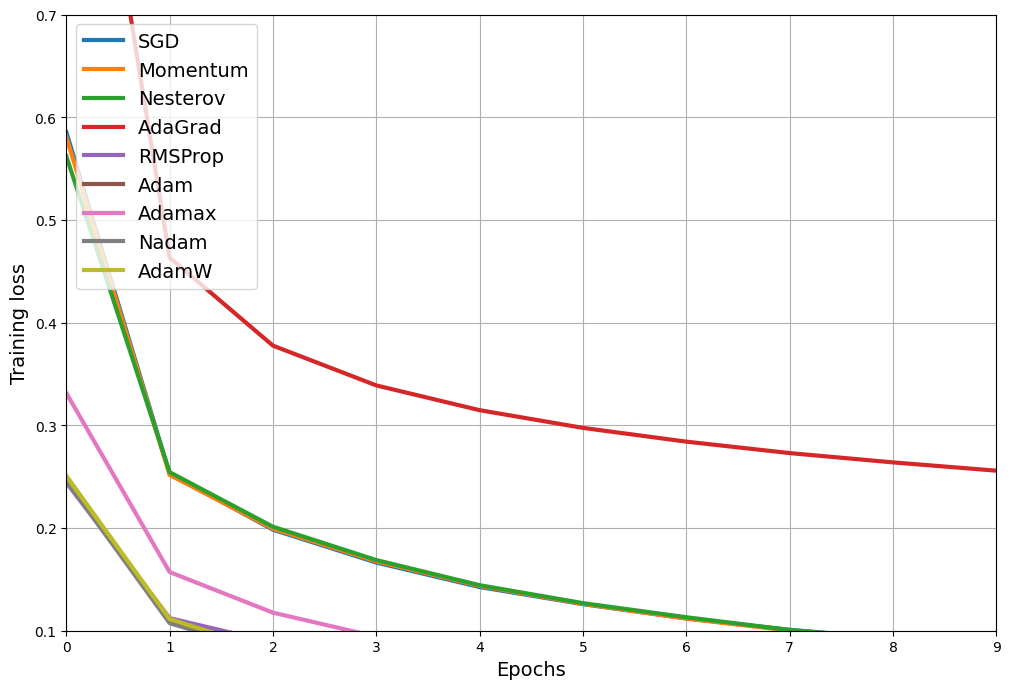

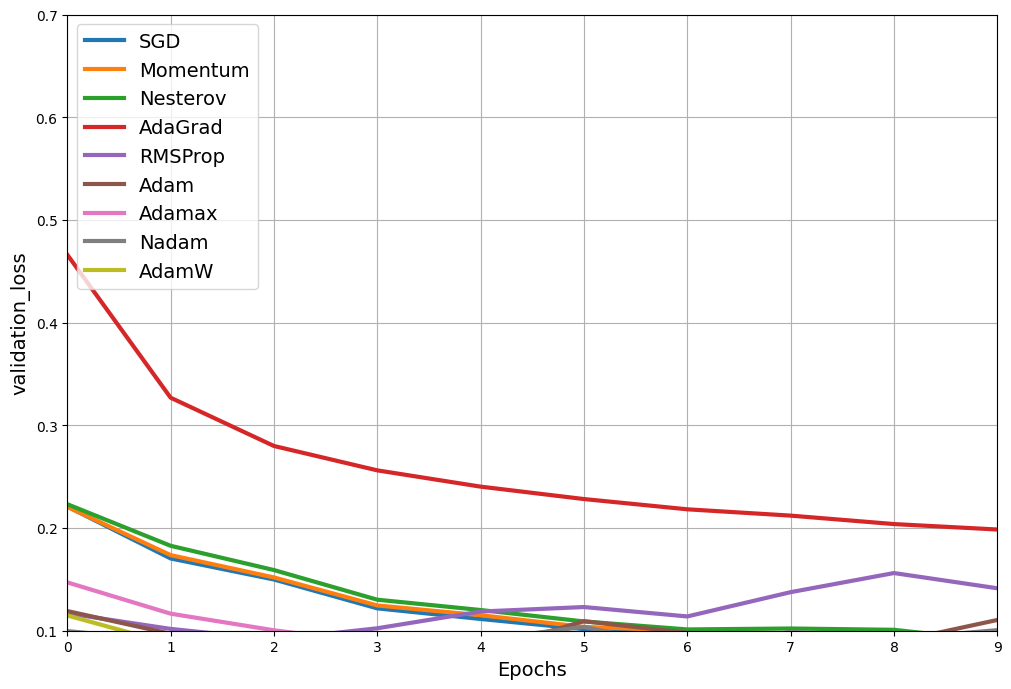

In [98]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                  opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)
    
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "validation_loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

*Optimizer comparison*
(* is bad, ** is average, *** is good).

| Class | Convergence speed | Convergence quality |
| --- | --- | --- |
| `SGD` | * | *** |
| `SGD(momentum=...)` | ** | *** |
| `SGD(momentum=..., nesterov=True)` | ** | *** |
| `Adagrad` | *** | *(stops too early) |
| `RMSProp` | *** | ** or *** |
| `Adam` | *** | ** or *** |
| `AdaMax` | *** | ** or *** |
| `Nadam` | *** | ** or *** |
| `AdamW` | *** | ** or *** |

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```

* Keras uses `c=1` and `s = 1 / decay`

In [99]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [101]:
history_power_scheduling = build_and_train_model(optimizer)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

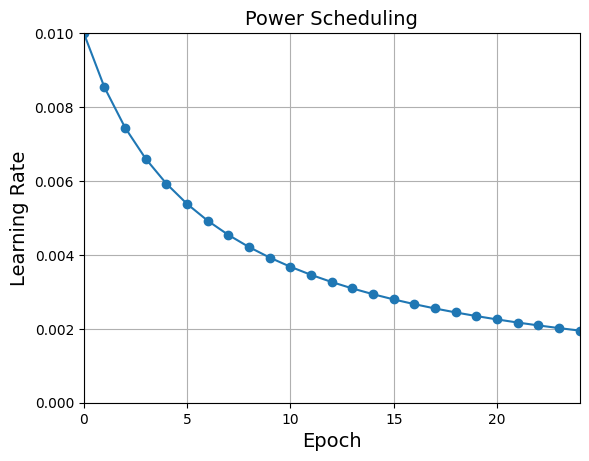

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s = 20)

In [ ]:
# build and compile a model for fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5927 - accuracy: 0.8309 - val_loss: 0.2214 - val_accuracy: 0.9410 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2543 - accuracy: 0.9256 - val_loss: 0.1739 - val_accuracy: 0.9528 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2019 - accuracy: 0.9405 - val_loss: 0.1445 - val_accuracy: 0.9606 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1712 - accuracy: 0.9500 - val_loss: 0.1327 - val_accuracy: 0.9652 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1501 - accuracy: 0.9566 - val_loss: 0.1178 - val_accuracy: 0.9694 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1361 - accuracy: 0.9604 - val_loss: 0.1168 - val_accuracy: 0.9666 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 4s

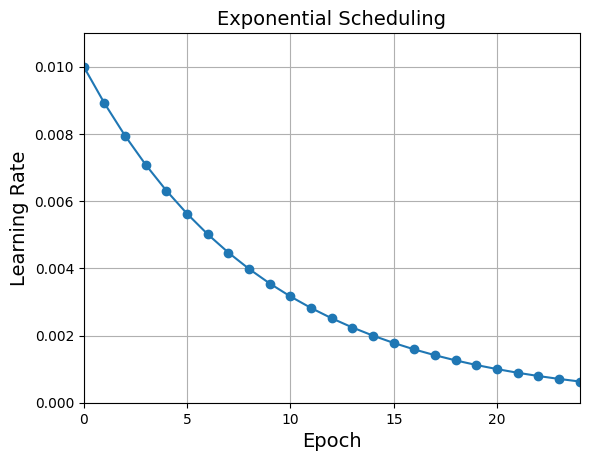

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [ ]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2654 - accuracy: 0.9241 - val_loss: 0.1792 - val_accuracy: 0.9512 - lr: 0.0083
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2107 - accuracy: 0.9392 - val_loss: 0.1610 - val_accuracy: 0.9564 - lr: 0.0076
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1768 - accuracy: 0.9493 - val_loss: 0.1363 - val_accuracy: 0.9608 - lr: 0.0069
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1547 - accuracy: 0.9554 - val_loss: 0.1281 - val_accuracy: 0.9632 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1385 - accuracy: 0.9600 - val_loss: 0.1182 - val_accuracy: 0.9654 - lr: 0.0058
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1265 - accuracy: 0.9634 - val_loss: 0.1186 - val_accuracy: 0.9662 - lr: 0.0052
Epoch 7/25
1719/1719 [==============================] - 10

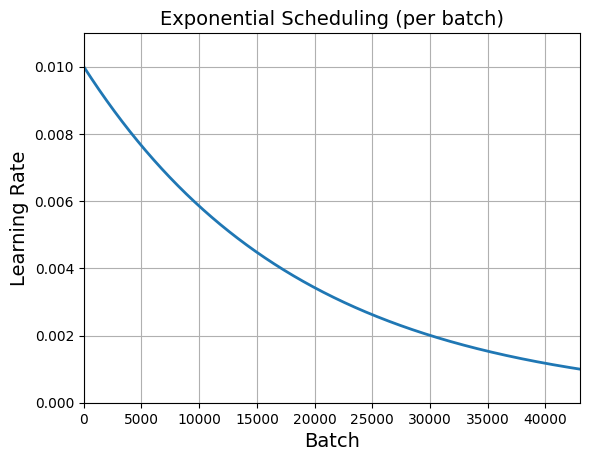

In [ ]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3095 - accuracy: 0.9105 - val_loss: 0.1762 - val_accuracy: 0.9504 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2083 - accuracy: 0.9453 - val_loss: 0.1565 - val_accuracy: 0.9570 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1779 - accuracy: 0.9540 - val_loss: 0.1326 - val_accuracy: 0.9662 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1663 - accuracy: 0.9582 - val_loss: 0.1348 - val_accuracy: 0.9652 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1535 - accuracy: 0.9621 - val_loss: 0.1320 - val_accuracy: 0.9676 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0916 - accuracy: 0.9758 - val_loss: 0.1088 - val_accuracy: 0.9726 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] -

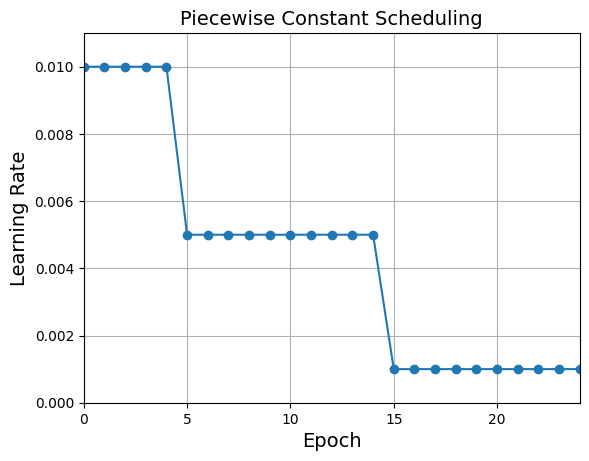

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5720 - accuracy: 0.8377 - val_loss: 0.2283 - val_accuracy: 0.9364 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2544 - accuracy: 0.9255 - val_loss: 0.1817 - val_accuracy: 0.9478 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2001 - accuracy: 0.9416 - val_loss: 0.1465 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1665 - accuracy: 0.9514 - val_loss: 0.1327 - val_accuracy: 0.9658 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1430 - accuracy: 0.9577 - val_loss: 0.1170 - val_accuracy: 0.9700 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1257 - accuracy: 0.9636 - val_loss: 0.1176 - val_accuracy: 0.9686 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 8s

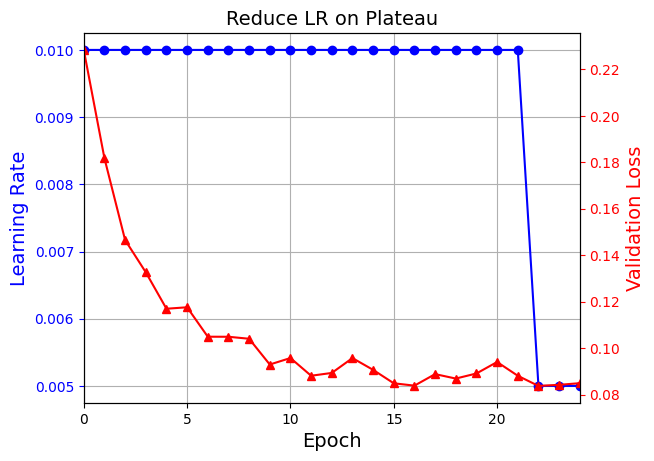

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation Loss", color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
import math

batch_size = 42
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [ ]:
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5354 - accuracy: 0.8465 - val_loss: 0.2214 - val_accuracy: 0.9426
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2566 - accuracy: 0.9238 - val_loss: 0.1760 - val_accuracy: 0.9508
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2077 - accuracy: 0.9389 - val_loss: 0.1459 - val_accuracy: 0.9612
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1783 - accuracy: 0.9482 - val_loss: 0.1367 - val_accuracy: 0.9640
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1585 - accuracy: 0.9542 - val_loss: 0.1253 - val_accuracy: 0.9668
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1441 - accuracy: 0.9580 - val_loss: 0.1199 - val_accuracy: 0.9658
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1324 - accuracy: 0.9619 - val_loss: 0.1117 - val_accuracy:

In [ ]:
# shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001]
)

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizers to their initial state.

In [ ]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use the maximum learning rate in 1cycle is near the bottom of the curve.

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 4ms/step - loss: 1.6899 - accuracy: 0.4203


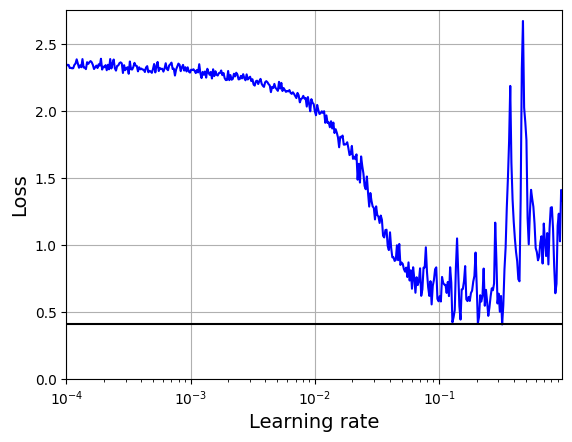

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning_rate to use for 1cycle is around 10<sup>-1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.9519 - accuracy: 0.7333 - val_loss: 0.3443 - val_accuracy: 0.9154
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3448 - accuracy: 0.9011 - val_loss: 0.2398 - val_accuracy: 0.9346
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.2605 - accuracy: 0.9240 - val_loss: 0.1862 - val_accuracy: 0.9484
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.2126 - accuracy: 0.9383 - val_loss: 0.1563 - val_accuracy: 0.9566
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1762 - accuracy: 0.9480 - val_loss: 0.1290 - val_accuracy: 0.9656
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1498 - accuracy: 0.9553 - val_loss: 0.1493 - val_accuracy: 0.9566
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1301 - accuracy: 0.9615 - val_loss: 0.1264 - val_accuracy: 0.9636
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

You can use $l_2$ regularization to constrain a neural network's connection weights, and/or $l_1$ regularization if you want a sparse model (with many weight equal to 0).

In [ ]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for $\ell_1$ regulariztion factor of 0.1 or `l1_l2(0.1, 0.01)` for both $\ell_1$ and $\ell_2$ regularization, with factors 0.1 and 0.01 respectively.

In [ ]:
tf.random.set_seed(42)

In [ ]:
from functools import partial

RegularizeDense = partial(tf.keras.layers.Dense,
                          activation="relu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizeDense(100),
    RegularizeDense(100),
    RegularizeDense(10, activation="softmax")
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 3.0451 - accuracy: 0.8625 - val_loss: 1.7059 - val_accuracy: 0.9320
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3279 - accuracy: 0.9056 - val_loss: 0.9789 - val_accuracy: 0.9298


$l_2$ regularization is fine when using SGD, momentum optimization, and Nesterov momentum optimization, but not with Adam and its variants. If you want to use Adam with weight decay, then do not use $l_2$ regularization: use AdamW instead.

## Dropout

*Dropout* was proposed in a paper by Geoffrey Hinton in 2012 and further detailed in a 2014 paper by Nitish Srivastava and it has proven to be highly successful.

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability *p* of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter *p* is called the *dropout rate*, and is typically set between 10% and 50%: closer to 20% - 30% in recurrent neural nets, and close to 40% - 50% in convolutional neural networks. After training, neurons don't get dropped anymore. And we also need to divide the connection weights by the *keep probability* $(1-p)$ during training.

In [ ]:
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4469 - accuracy: 0.8613 - val_loss: 0.1353 - val_accuracy: 0.9630
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2497 - accuracy: 0.9239 - val_loss: 0.1008 - val_accuracy: 0.9728
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2077 - accuracy: 0.9367 - val_loss: 0.0874 - val_accuracy: 0.9728
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1823 - accuracy: 0.9446 - val_loss: 0.0833 - val_accuracy: 0.9754
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1681 - accuracy: 0.9476 - val_loss: 0.0792 - val_accuracy: 0.9780
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1581 - accuracy: 0.9516 - val_loss: 0.0711 - val_accuracy: 0.9800
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1473 - accuracy: 0.9543 - val_loss: 0.0747 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy.

In [ ]:
model.evaluate(X_train, y_train)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
model.evaluate(X_test, y_test)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [ ]:
tf.random.set_seed(42)

In [ ]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Averaging over multiple predictions with dropout turned one gives us a Monte Carlo estimate that is generally more reliable than a single prediction with dropout turned off.

In [ ]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 52ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.999, 0.   ,
       0.   ], dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.002, 0.003, 0.   , 0.   , 0.   , 0.004, 0.   ,
       0.001], dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.9777

In [ ]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [ ]:
# how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [ ]:
mc_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_111 (Dense)           (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_112 (Dense)           (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_113 (Dense)           (None, 10)              

Now we can use the model with MC Dropout:

In [ ]:
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 32ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

## Max norm

In [ ]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [ ]:
# how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Excercises

## 1. to 7.

1. Glorot Initialization and He initialization aims to fix the problem of vanishing/exploding gradients in the case of training deep neural network. These were designed to make the output standard deviation close as possible to the input standard deviation, at least at the beginning of training.
2. No, all weights must be set independent of the others, setting all the weights equal will make backpropagation fail not work properly. (**answer from the book**: all weights should be sampled indepently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same value, this symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.)
3. It is fine to initialize the bias terms to zero.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between -1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g, for binary classification), but it is rarely used in the hidden layers. The softplus activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely used in hidden layers.
5. If `momentum` hyperparameter is set too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed. Also when it is near minimum, it will overshoot. Then it will slow down and come back, overshoot again, and so on.
6. To get a sparse model, we can set the small weights to zero, we can use $\ell_1$ regularization during training, or we can use the TensorFlow Model Optimization Toolkit.
7. Dropout slows down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a. Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this excercise). Use He initialization and the Swish activation function function.

In [ ]:
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="swish",
                                    kernel_initializer="he_normal"))
                

### b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 * 32-pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for right learning rate each time you change the model's architecture or hyperparameters. 

**Note**: I have been unable to check for the optimal learning rate till now, so I used the learning rate which was mentioned in the solution.

In [ ]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_valid, y_valid = X_train_full[:5000], y_train_full[:5000]
# X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [ ]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog",
            "frog", "horse", "ship", "truck"]

In [ ]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, metrics="accuracy")

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                    restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                        save_best_only=True)
run_index = 1  # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard()
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 43s 26ms/step - loss: 4.0308 - accuracy: 0.1645 - val_loss: 2.1611 - val_accuracy: 0.2228
Epoch 2/100
1407/1407 [==============================] - 29s 20ms/step - loss: 2.0548 - accuracy: 0.2437 - val_loss: 2.0996 - val_accuracy: 0.2248
Epoch 3/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.9488 - accuracy: 0.2823 - val_loss: 1.9614 - val_accuracy: 0.3006
Epoch 4/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.8648 - accuracy: 0.3195 - val_loss: 1.8958 - val_accuracy: 0.3246
Epoch 5/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.7994 - accuracy: 0.3472 - val_loss: 1.8003 - val_accuracy: 0.3462
Epoch 6/100
1407/1407 [==============================] - 29s 20ms/step - loss: 1.7482 - accuracy: 0.3656 - val_loss: 1.7597 - val_accuracy: 0.3638
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.7067 - accuracy: 0.3850 - val_loss: 1

In [ ]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4783 - accuracy: 0.4954


[1.4783128499984741, 0.49540001153945923]

### c. Now try adding batch normalization and compare the learning curves: is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, metrics="accuracy")

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increase every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 74s 52ms/step - loss: 1.0831 - accuracy: 0.6181 - val_loss: 1.5233 - val_accuracy: 0.4952
Epoch 2/100
1407/1407 [==============================] - 51s 36ms/step - loss: 1.0685 - accuracy: 0.6234 - val_loss: 1.5244 - val_accuracy: 0.4894
Epoch 3/100
1407/1407 [==============================] - 62s 44ms/step - loss: 1.0560 - accuracy: 0.6285 - val_loss: 1.5420 - val_accuracy: 0.4856
Epoch 4/100
1407/1407 [==============================] - 70s 50ms/step - loss: 1.0440 - accuracy: 0.6322 - val_loss: 1.5097 - val_accuracy: 0.4856
Epoch 5/100
1407/1407 [==============================] - 65s 46ms/step - loss: 1.0282 - accuracy: 0.6382 - val_loss: 1.4393 - val_accuracy: 0.5168
Epoch 6/100
1407/1407 [==============================] - 67s 48ms/step - loss: 1.0130 - accuracy: 0.6425 - val_loss: 1.5301 - val_accuracy: 0.4784
Epoch 7/100
1407/1407 [==============================] - 75s 53ms/step - loss: 1.0003 - accuracy: 0.6482 - val_loss: 1

In [ ]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 3s 15ms/step - loss: 1.4393 - accuracy: 0.5168


[1.4393150806427002, 0.5167999863624573]

* When batch normalization was implemented after activation function it took 60 mins to train whereas the training without batch normalization took 25 mins. In the case where batch normalization was applied before activation function it took 24 mins whereas without batch normalization, training took 27 mins.

* Batch Normalization (after activation function) increases the accuracy on validation set from 46.58% to 51.52%.
In the case of batch normalization before activation function, accuracy on validation set increased from 49.54% to 51.68%

* Training an epoch takes twice the time when batch normalization is implemented but the this is counterbalanced by the fact that the model trains for lesser epochs to reach optimum.

### d. Try replacing batch normalization with SELU, and make the necessay adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normalization, make sure the DNN contains only a sequence of dense layers, etc.)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_selu_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]


In [ ]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 69s 42ms/step - loss: 1.9213 - accuracy: 0.3120 - val_loss: 1.8072 - val_accuracy: 0.3630
Epoch 2/100
1407/1407 [==============================] - 57s 41ms/step - loss: 1.7112 - accuracy: 0.3918 - val_loss: 1.6828 - val_accuracy: 0.4062
Epoch 3/100
1407/1407 [==============================] - 54s 38ms/step - loss: 1.6151 - accuracy: 0.4297 - val_loss: 1.6337 - val_accuracy: 0.4116
Epoch 4/100
1407/1407 [==============================] - 58s 41ms/step - loss: 1.5441 - accuracy: 0.4562 - val_loss: 1.6251 - val_accuracy: 0.4382
Epoch 5/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.4859 - accuracy: 0.4788 - val_loss: 1.6339 - val_accuracy: 0.4350
Epoch 6/100
1407/1407 [==============================] - 56s 40ms/step - loss: 1.4415 - accuracy: 0.4941 - val_loss: 1.5252 - val_accuracy: 0.4594
Epoch 7/100
1407/1407 [==============================] - 50s 35ms/step - loss: 1.3968 - accuracy: 0.5094 - val_loss: 1

In [ ]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4832 - accuracy: 0.4940


[1.4831706285476685, 0.49399998784065247]

### e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increase every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 33s 20ms/step - loss: 1.8840 - accuracy: 0.3303 - val_loss: 1.7662 - val_accuracy: 0.3870
Epoch 2/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6542 - accuracy: 0.4159 - val_loss: 1.7209 - val_accuracy: 0.3888
Epoch 3/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5615 - accuracy: 0.4509 - val_loss: 1.6230 - val_accuracy: 0.4296
Epoch 4/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.4959 - accuracy: 0.4756 - val_loss: 1.5733 - val_accuracy: 0.4480
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4364 - accuracy: 0.4967 - val_loss: 1.5941 - val_accuracy: 0.4662
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.3906 - accuracy: 0.5164 - val_loss: 1.5014 - val_accuracy: 0.4780
Epoch 7/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3456 - accuracy: 0.5285 - val_loss: 1

In [ ]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4714 - accuracy: 0.5110


[1.4714148044586182, 0.5109999775886536]

The model achieves almost the same accuracy as the model without `Alpha Dropout`

Use MC Dropout now.

In [ ]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

In [ ]:
import numpy as np

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

157/157 [==============================] - 1s 4ms/step


0.5134

### f. Retrain the model using 1cycle scheduling and see if it improves training speed and model accuracy

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_loss",
            optimizer=optimizer,
            metrics=["accuracy"])

In [ ]:
import math

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])